## Triplet loss
### Train a linear embedding space with triplet loss

> Adapt this code to train a linear embedding that takes as inputs 1-hot encoding of digits 0 to 9, and outputs a 2D-embedding. Then train this embedding with a triplet loss in order to shape the embedding space so that the digits appear ordered in the embedding space. Plot the embedding space with matplotlib.

[Slides](https://olki.loria.fr/cerisara/lexres/2024td1.html#/4/6)

In [32]:
import torch
import pytorch_lightning as pl
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [33]:
# Pytorch dataset that generates one triple
class NTripDS(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()

    def __len__(self):
        return 1000

    def __getitem__(self,i):
        va = torch.randint(0, 10, (1,))
        vb = torch.randint(0, 10, (1,))
        vc = torch.randint(0, 10, (1,))
        xa = F.one_hot(va, num_classes=10).float()
        b = F.one_hot(vb, num_classes=10).float()
        c = F.one_hot(vc, num_classes=10).float()
        if math.fabs(vb-va) <= math.fabs(vc-va):
            xp,xn = b,c
        else:
            xp,xn = c,b
        return xa,xp,xn

In [34]:
class Mod(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.W = torch.nn.Linear(10,2)

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr = 1e-3)
        return opt

    def forward(self, x):
        e = self.W(x)
        return e

    def training_step(self, batch, batch_idx):
        anc, pos, neg = batch
        ea = self.W(anc)
        ep = self.W(pos)
        en = self.W(neg)
        dp = torch.nn.functional.triplet_margin_loss(ea,ep,en)
        self.log("train_loss", dp, on_step=False, on_epoch=True)
        return dp

In [35]:
def plot(mod):
    x = F.one_hot(torch.arange(0,10)).float()
    y = mod(x)
    ny = y.detach().numpy()
    x = ny[:,0]
    y = ny[:,1]
    for i in range(len(x)):
        plt.annotate(f"{i}", (x[i],y[i]))
    plt.scatter(x, y)
    plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name | Type   | Params | Mode 
----------------------------------------
0 | W    | Linear | 22     | train
----------------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


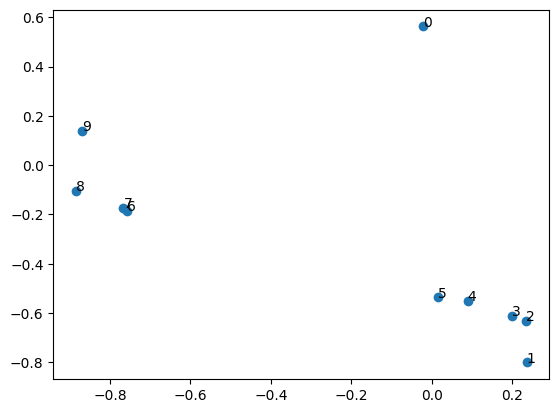

In [36]:
traindata = NTripDS()
trainloader = torch.utils.data.DataLoader(traindata, batch_size=1, shuffle=False)
mod = Mod()
# logger = pl.loggers.TensorBoardLogger(save_dir="logs/", flush_secs=1)
trainer = pl.Trainer(limit_train_batches=1.0, max_epochs=3, log_every_n_steps=1)
trainer.fit(model=mod, train_dataloaders=trainloader)

#Â to view the training curves:
# tensorboard --logdir=lightning_logs/

plot(mod)